In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### High-dimensional vectors
To get an intuition about the working of the PCA, we used an example in the plane, or $R^2$.
While useful for intuition, this is not the typical case in which we use PCA. Typically we are interested in vectors in a space whose dimension is in the hundreds or more.

How can we depict such vectors? If the coordinates of the vector have a natural order. For example, if the coordinates correspond to a grid of times, then a good representation is to make a plot in which the $x$-axis is the time and the $y$-axis is the value that corresponds to this time. 

Later in this class we will consider vectors that correspond to the temperature at a particular location each day of the year. These vectors will be of length 365 (we omit the extra days of leap years) and the PCA analysis will reveal the low dimensional subspace.

### Function approximation
For now, we will consider the vectors that are defined by sinusoidal functions.

In [2]:
# We define a grid that extends from o to 2*pi
step=2*pi/365
x=arange(0,2*pi,step)
len(x)

365

### Define a basis

The dimension of the space is 629.

We define some functions based on $\sin()$ and $\cos()$ 

In [3]:
c=sqrt(step/(pi))
v=[]
v.append(np.array(cos(0*x))*c/sqrt(2))
v.append(np.array(sin(x))*c)
v.append(np.array(cos(x))*c)
v.append(np.array(sin(2*x))*c)
v.append(np.array(cos(2*x))*c)
v.append(np.array(sin(3*x))*c)
v.append(np.array(cos(3*x))*c)
v.append(np.array(sin(4*x))*c)
v.append(np.array(cos(4*x))*c)

print"v contains %d vectors"%(len(v))


v contains 9 vectors


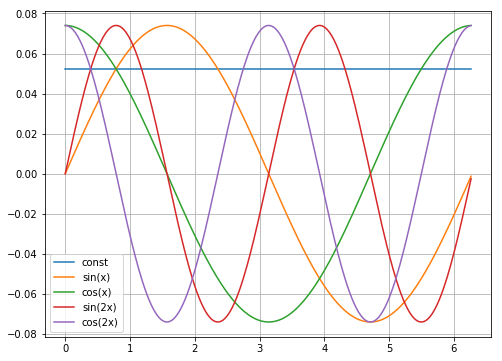

In [4]:
# plot some of the functions (plotting all of them results in a figure that is hard to read.
figure(figsize=(8,6))
for i in range(5):
    plot(x,v[i])
grid()
legend(['const','sin(x)','cos(x)','sin(2x)','cos(2x)'])

### This is an orthonormal basis
This basis is not **complete** it does not span the space of all functions. It spans a 9 dimensional sub-space.

We will now check that this is an **orthonormal** basis. In other words, the length of each vector is 1 and every pair of vectors are orthogonal.

-0.0

In [21]:
for i in range(len(v)): 
    print
    for j in range(len(v)):
        a=dot(v[i],v[j])
        a=round(a*1000.+.1)/1000. #rounding is needed to remove numbers like -0.0
        print '%2.0f'%a,


 1  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0
 0  0  0  0  1  0  0  0  0
 0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  1


### Rewriting the basis as a matrix

Combining the vectors as rows in a matrix allows us use very succinct (and very fast) matrix multiplications instead of for loops with vector products.

In [22]:
U=vstack(v)
shape(U)

(9, 365)

### Approximating a function
We now take an unrelated function $f=|x-4|$
and see how we can use the basis matrix `U` to approximate it. 

In [23]:
f=abs(x-4)

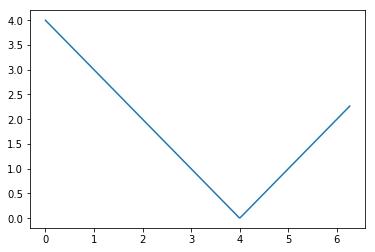

In [24]:
plot(x,f);

### Approximations  of increasing accuracy
To understand the workings of the basis, we create a sequence of approximations $g(i)$ such that $g(i)$ is an approximation that uses the first $i$ vectors in the basis.

The larger $i$ is, the closer $g(i)$ is to $f$. Where the distance between $f$ and $g(i)$ is defined by the euclidean norm:
$$   \| g(i)- f \|_2
$$

### Plotting the approximations
Below we show how increasing the number of vectors in the basis improves the approximation of $f$.

In [25]:
import sys
sys.path.append('lib')

In [26]:
from recon_plot import recon_plot
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter

In [31]:
# %load lib/recon_plot.py
import numpy as np
from YearPlotter import YearPlotter
from Eigen_decomp import Eigen_decomp
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

class recon_plot:
    """A class for creating an interactive demonstration of approximating 
    a function with an orthonormal set of function"""
    def __init__(self,eigen_decomp,year_axis=False,fig=None,ax=None,interactive=False,Title=None):
        """ 

        :param eigen_decomp: An Eigen_decomp object that encapsulate the numerical calculations for the decomposition.
        :param year_axis: If True: assumes vectors of length 365 and plots month names on X axis
        :param fig: The fig environment for plotting
        :param ax: The axis environment for plotting (used for generating multi-plots)
        :param interactive: Set to True if you want to use the plot in an interactive reconstruction Widget.
        :param Title: A string to be used as the title of this plot.
        """
        self.eigen_decomp=eigen_decomp
        self.interactive=interactive
        self.fig=fig
        self.ax=ax
        self.Title=Title
        
        self.year_axis=year_axis
        self.yearPlotter=None
        if year_axis:
            self.yearPlotter=YearPlotter()
        self.plot_combination(**self.eigen_decomp.coeff)
        return None

    def get_widgets(self):
        """return the slider widget that are to be used

        :returns: widget_list: the list of widgets in order
                  widget_dict: a dictionary of the widget to be used in `interact

        :todo: make the sliders smaller: http://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
        """
        coeff=self.eigen_decomp.C
        widge_dict={}
        widge_list=[]
        for i in range(self.eigen_decomp.n):
            if coeff[i]>0:
                r=[0,coeff[i]*2]
            else:
                r=[coeff[i]*2,0]

            widge_list.append(widgets.FloatSlider(min=r[0],max=r[1],step=coeff[i]/10.,\
                                                  value=coeff[i],orientation='vertical',decription='v'+str(i)))
            widge_dict['c'+str(i)]=widge_list[-1]

        return widge_list,widge_dict

    def plot(self,y,label=''):
        if self.year_axis:
            self.yearPlotter.plot(y,self.fig,self.ax,label=label)
        else:
            self.ax.plot(self.eigen_decomp.x,y,label=label);

    def plot_combination(self,**coeff):
        """
        the plotting function that performs the actual rendering. It is called either directly (non-interactive) or by 
        `interactive` when used in a widget.

        :coeff: a dictionary that contains the name and value of each coefficient
        :returns: None

        """
        print 'in plot_combination', coeff,'\n'
        return None
#        if self.interactive or (self.fig is None):
        if self.fig is None:
            self.fig=plt.figure(figsize=(8,6))
            self.ax=self.fig.add_axes([0,0,1,1])
        else:
            self.fig.clear()

        A=self.eigen_decomp.mean
        self.plot(A,label='mean')

        for i in range(self.eigen_decomp.n):
            g=self.eigen_decomp.v[i]*coeff['c'+str(i)]
            A=A+g
            self.plot(A,label='cumul '+str(i))
        self.plot(self.eigen_decomp.f,label='target')
        self.ax.grid(figure=self.fig)        
        self.ax.legend()
        self.ax.set_title(self.Title)
        return None
    


In [32]:
eigen_decomp=Eigen_decomp(x,f,np.zeros(len(f)),v)
recon_plot(eigen_decomp,year_axis=False);

in plot_combination {'c8': 1.1159489565455394, 'c3': 1.5637963122785816, 'c2': 14.285464698745864, 'c1': 13.890978134306334, 'c0': 32.295705593489487, 'c7': 1.9996291633161007, 'c6': 0.21303639374730732, 'c5': 2.9729921563972925, 'c4': 2.52664091580312} 



In [33]:
import numpy as np
from ipywidgets import interactive,widgets
eigen_decomp=Eigen_decomp(x,f,np.zeros(len(f)),v)
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True);
widge_list,widge_dict = plotter.get_widgets()
interactive(plotter.plot_combination, **widge_dict)
widgets.VBox([widgets.HBox(widge_list)])

in plot_combination {'c8': 1.1159489565455394, 'c3': 1.5637963122785816, 'c2': 14.285464698745864, 'c1': 13.890978134306334, 'c0': 32.295705593489487, 'c7': 1.9996291633161007, 'c6': 0.21303639374730732, 'c5': 2.9729921563972925, 'c4': 2.52664091580312} 



In [29]:
plotter.fig.clear()

AttributeError: 'NoneType' object has no attribute 'clear'

### Excercise
Visually, it is clear that $g(i)$ is getting close to $f$ as $i$ increases. To quantify the improvement, calculate 
$ \| g(i)- f \|_2 $ as a function of $i$